### Scan PDF text extraction
If the PDF is a scan, then it needs to be OCR'ed. In this repo Azure OCR is used, however any OCR engine could work.
Azure Document OCR returns just the text, not the PDF with the text overlayed.

In [1]:
import io
import os
import matplotlib.pyplot as plt
from statistics import mode

import pymupdf
from azure.ai.formrecognizer import DocumentAnalysisClient
from azure.core.credentials import AzureKeyCredential
from dotenv import load_dotenv
from PIL import Image
from pymupdf import Rect

%matplotlib inline

In [2]:
load_dotenv()
endpoint = os.environ["AZURE_DOCUMENT_INTELLIGENCE_URL"]
key = os.environ["AZURE_DOCUMENT_INTELLIGENCE_KEY"]

In [3]:
pdf_file = "resources/19071901.pdf"
pdf = pymupdf.open(pdf_file)
# convert PDF to bytes
pdf_bytes_io = io.BytesIO()
pdf.save(pdf_bytes_io)
pdf_bytes = pdf_bytes_io.getvalue()

In [4]:
# the result contains all text, however similar to the digital pdf, the interest lies in the
# text within the dotted lines.
di_client = DocumentAnalysisClient(endpoint=endpoint, credential=AzureKeyCredential(key))
poller = di_client.begin_analyze_document(model_id="prebuilt-read", document=pdf_bytes)
result = poller.result()

extract only the text within the dotted lines

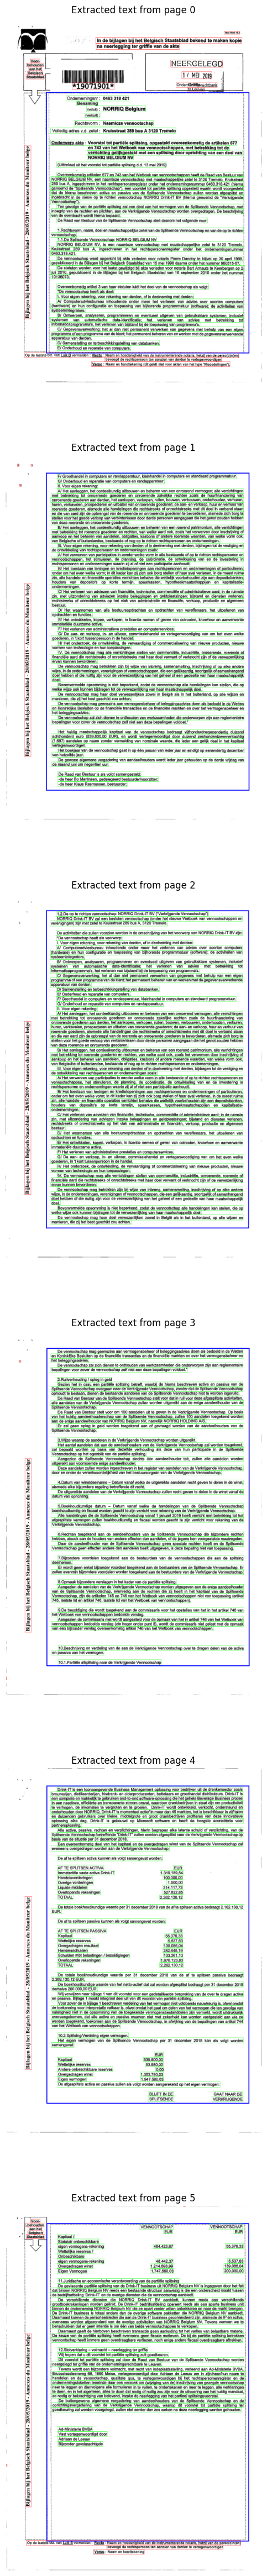

In [5]:
PAGE_0_REL_COORDS = (0.15966, 0.20485, 0.95, 0.91950)
PAGE_N_REL_COORDS = (0.15966, 0.04899, 0.95, 0.91950)

fig, axes = plt.subplots(len(pdf), figsize=(15, 10 * len(pdf)))

# Filter lines based on the coordinates
text = ""
for ocr_page, scan_page in zip(result.pages, pdf):
    _, _, width, height = scan_page.rect
    sf_x, sf_y = width / ocr_page.width, height / ocr_page.height  # scaling factor
    if scan_page.number == 0:
        rel_coords = PAGE_0_REL_COORDS
    else:
        rel_coords = PAGE_N_REL_COORDS

    crop = (rel_coords[0] * width, rel_coords[1] * height, rel_coords[2] * width, rel_coords[3] * height)
    rect = Rect(x0=crop[0], y0=crop[1], x1=crop[2], y1=crop[3])
    scan_page.draw_rect(rect, color=(0, 0, 1), width=2)

    for line in ocr_page.lines:
        x_coords = [point.x for point in line.polygon]
        y_coords = [point.y for point in line.polygon]
        x0, y0, x1, y1 = min(x_coords) * sf_x, min(y_coords) * sf_y, max(x_coords) * sf_x, max(y_coords) * sf_y
        rect = Rect(x0=x0, y0=y0, x1=x1, y1=y1)
        if crop[0] <= x0 and x1 <= crop[2] and crop[1] <= y0 and y1 <= crop[3]:
            line_text = (
                line.content
                if not text or text.endswith("\n") or line.content.startswith("\n")
                else "\n" + line.content
            )
            text += line_text
            color = (0, 1, 0)
        else:
            color = (1, 0, 0)

        # visually show which lines are extracted and which are not
        scan_page.draw_rect(rect, color=color, width=0.5)

    pix = scan_page.get_pixmap()
    image = Image.open(io.BytesIO(pix.tobytes("png")))
    axes[scan_page.number].imshow(image)
    axes[scan_page.number].axis("off")
    axes[scan_page.number].set_title(f"Extracted text from page {scan_page.number}")

plt.show()

On page 4 and 5 there are some tables, let's ensure that our text extraction properly deals with those

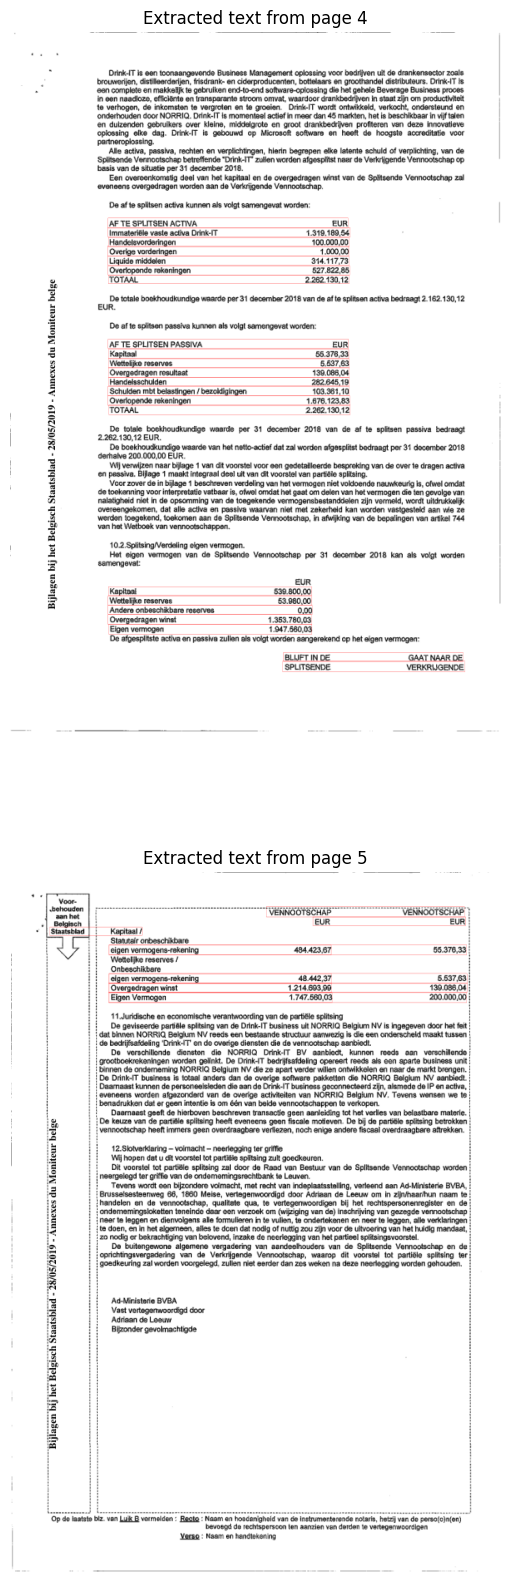

In [6]:
pdf_file = "resources/19071901.pdf"
pdf = pymupdf.open(pdf_file)

fig, axes = plt.subplots(2, figsize=(15, 10 * 2))
for i, (ocr_page, scan_page) in enumerate(zip(result.pages[4:6], pdf[4:6])):
    _, _, width, height = scan_page.rect
    sf_x, sf_y = width / ocr_page.width, height / ocr_page.height  # scaling factor

    line_coords = [[point.y for point in line.polygon] for line in ocr_page.lines]
    line_height = mode([max(coords) - min(coords) for coords in line_coords]) * sf_y

    px0 = py0 = px1 = py1 = p_line_text = None
    lines = sorted(
        ocr_page.lines,
        key=lambda line: (min(point.y for point in line.polygon), min(point.x for point in line.polygon)),
    )
    for line in lines:
        line_text = line.content
        x_coords = [point.x for point in line.polygon]
        y_coords = [point.y for point in line.polygon]
        x0, y0, x1, y1 = min(x_coords) * sf_x, min(y_coords) * sf_y, max(x_coords) * sf_x, max(y_coords) * sf_y
        if (
            py0
            and py1
            and abs(py0 - y0) / y0 <= 0.05
            and abs(py1 - y1) / y1 <= 0.05
            and (max(y1, py1) - min(y0, py0)) <= line_height * 1.25
        ):
            rect = Rect(x0=min(x0, px0), y0=min(y0, py0), x1=max(x1, px1), y1=max(y1, py1))
            scan_page.draw_rect(rect, color=(1, 0, 0), width=0.2)
        px0, py0, px1, py1, p_line_text = x0, y0, x1, y1, line_text

    pix = scan_page.get_pixmap()
    image = Image.open(io.BytesIO(pix.tobytes("png")))
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Extracted text from page {scan_page.number}")

plt.show()

perfect, for those lines considered on the same height, let's separate them with a tab (\t) instead of a newline (\n).
Ordering the text correctly in a PDF is a tricky job and there is no perfect solution. 

In [7]:
PAGE_0_REL_COORDS = (0.15966, 0.20485, 0.95, 0.91950)
PAGE_N_REL_COORDS = (0.15966, 0.04899, 0.95, 0.91950)
# Filter lines based on the coordinates
text = ""
for ocr_page, scan_page in zip(result.pages, pdf):
    _, _, width, height = scan_page.rect
    sf_x, sf_y = width / ocr_page.width, height / ocr_page.height  # scaling factor
    line_coords = [[point.y for point in line.polygon] for line in ocr_page.lines]
    line_height = mode([max(coords) - min(coords) for coords in line_coords]) * sf_y
    if scan_page.number == 0:
        rel_coords = PAGE_0_REL_COORDS
    else:
        rel_coords = PAGE_N_REL_COORDS

    crop = (rel_coords[0] * width, rel_coords[1] * height, rel_coords[2] * width, rel_coords[3] * height)

    px0 = py0 = px1 = py1 = p_line_text = None
    lines = sorted(
        ocr_page.lines,
        key=lambda line: (min(point.y for point in line.polygon), min(point.x for point in line.polygon)),
    )
    for line in lines:
        x_coords = [point.x for point in line.polygon]
        y_coords = [point.y for point in line.polygon]
        x0, y0, x1, y1 = min(x_coords) * sf_x, min(y_coords) * sf_y, max(x_coords) * sf_x, max(y_coords) * sf_y
        within_crop = crop[0] <= x0 and x1 <= crop[2] and crop[1] <= y0 and y1 <= crop[3]
        same_line = (
            py0
            and py1
            and abs(py0 - y0) / y0 <= 0.05
            and abs(py1 - y1) / y1 <= 0.05
            and (max(y1, py1) - min(y0, py0)) <= line_height * 1.25
        )

        if not within_crop:
            continue

        if same_line:
            text += "\t" + line.content
        else:
            line_text = (
                line.content
                if not text or text.endswith("\n") or line.content.startswith("\n")
                else "\n" + line.content
            )
            text += line_text

        px0, py0, px1, py1, p_line_text = x0, y0, x1, y1, line_text

print(text)

Ondernemingsnr : 0463 318 421
Benaming
(voluit) : NORRIQ Belgium
(verkort) :
Rechtsvorm : Naamloze vennootschap
Volledig adres v.d. zetel : Kruisstraat 289 bus A 3120 Tremelo
Onderwerp akte : Voorstel tot partiële splitsing, opgesteld overeenkomstig de artikelen 677
en 743 van het Wetboek van vennootschappen, met betrekking tot de
verrichting gelijkgesteld met een splitsing door oprichting van een deel van
NORRIQ BELGIUM NV
(Uittreksel uit het voorstel tot partiële splitsing d.d. 13 mei 2019)
Overeenkomstig artikelen 677 en 743 van het Wetboek van vennootschappen heeft de Raad van Bestuur van:
NORRIQ BELGIUM NV, een naamloze vennootschap met maatschappelijke zetel te 3120 Tremelo, Kruisstraat:
289 bus A, ingeschreven in het rechtspersonenregister onder het ondernemingsnummer 0463.318.421 (hierna;
genoemd de "Splitsende Vennootschap"), een voorstel tot partiële splitsing opgesteld waarin wordt voorgesteld
dat de hierna beschreven activa en passiva van de Splitsende Vennootschap zullen w